## Setup Notebook

This section installs and imports the necessary modules for running this notebook. It also initializes necessary functions and constants.

Run all cells in this section to setup the notebook.

In [62]:
!pip install altair

In [63]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import os
import altair
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [64]:
# Library functions
def subtract_dmso(df, ndims):
  """Subtracts average DMSO embedding per plate."""
  dmso_wells = df[df['compound'] == 'DMSO']
  dmso_wells = dmso_wells.groupby('plate')[list(range(ndims))].agg(np.mean)
  mask = df['plate'].isin(dmso_wells.index)
  print('Dropping %d rows' % (~mask).sum())
  df = df[mask]
  matched_dmso = dmso_wells.loc[df['plate']][list(range(ndims))].values
  df.loc[:, list(range(ndims))] = df[list(range(ndims))].values - matched_dmso
  return df


def add_tsne_embedding(data_df,
                       ndims=512,
                       perplexity=10,
                       n_iter=5000,
                       seed=None):
  """Add t-SNE embedding to dataframe assuming embedding."""
  tsne_embedding = (
      TSNE(
          n_components=2,
          perplexity=perplexity,
          learning_rate=5,
          random_state=seed,
          n_iter=n_iter,
          n_jobs=32).fit_transform(data_df[range(ndims)].values))
  data_df['tsne_x'] = tsne_embedding[:, 0]
  data_df['tsne_y'] = tsne_embedding[:, 1]
  return data_df


def get_subset(data_df, **kwargs):
  """Subsets dataframe based on column values provided."""
  subset_df = data_df
  for col, val in kwargs.items():
    if val is None:
      continue
    subset_df = subset_df[subset_df[col] == val]
  return subset_df


def get_pdist_distributions(df,
                            group1_kwargs,
                            group2_kwargs=None,
                            ndims=512,
                            groupby_cols=None,
                            metric='euclidean',
                            exclude_same_cols=None):
  """Returns pairwise dist between elements of grp 1 and between grps 1 and 2.

  Specifically:
    1. It uses group1_kwargs / group2_kwargs to filter elements of df.
    2. It groups group1 / 2 by `groupby_cols`, averaging the embeddings.
    3. It computes `within_group_distances`, which is distance of each element
       of group 1 from other elements of group 1 as long as
       they don't share the exact same values of cols in `exclude_same_cols`.
    4. It computes `between_group_distances`, which is distance of each element
       of group 1 from elements of group 2 as long as
       they don't share the exact same values of cols in `exclude_same_cols`.

  Args:
    df: Dataframe containing (1) metadata for each example and (2) columns
        named 1...n_dims containing the embeddings for each example.
    group1_kwargs: List of column name and values to filter `df` to get group 1.
    group2_kwargs: List of column name and values to filter `df` to get group 2.
    ndims: Number of embedding dimensions.
    groupby_cols: Columns to use to average embeddings.
    metric: Metric to use to compute pairwise distances.
    exclude_same_cols: Entries that share the same values of `exclude_same_cols`
                       will be excluded from the pairwise distance distribution.

  Returns:
    within_group_distances: Distances between elements of df that are in group 1
                            that don't share values of `exclude_same_col`.
    between_group_distances: Distances between elements of df that are in
                             group 1 and elements of df in group 2 that don't
                             share values of `exclude_same_col`.
  """
  group1_elements = get_subset(df, **group1_kwargs)
  if group2_kwargs is None:
    group2_elements = df
  else:
    group2_elements = get_subset(df, **group2_kwargs)
  # Exclude group 1 from group 2
  mask = group2_elements.index.isin(group1_elements.index.values)
  group2_elements = group2_elements[~mask]

  if groupby_cols is not None:
    group1_elements = (
        group1_elements.groupby(groupby_cols)[list(
            range(ndims))].mean().reset_index())
    group2_elements = (
        group2_elements.groupby(groupby_cols)[list(
            range(ndims))].mean().reset_index())

  within_group_distances = squareform(
      pdist(group1_elements[list(range(ndims))].values, metric=metric))
  exclusion_mask = np.zeros_like(within_group_distances).astype(bool)
  for col in exclude_same_cols:
    grp1_values = group1_elements[col].values
    partial_mask = grp1_values[:, None] == grp1_values[None, :]
    exclusion_mask |= partial_mask
  within_group_distances = within_group_distances[~exclusion_mask].flatten()

  between_group_distances = cdist(group1_elements[list(range(ndims))].values,
                                  group2_elements[list(range(ndims))].values,
                                  metric=metric)
  exclusion_mask = np.zeros_like(between_group_distances).astype(bool)
  for col in exclude_same_cols:
    grp1_values = group1_elements[col].values[:, None]
    grp2_values = group2_elements[col].values[None, :]
    partial_mask = grp1_values == grp2_values
    exclusion_mask |= partial_mask
  between_group_distances = between_group_distances[~exclusion_mask].flatten()
  return within_group_distances, between_group_distances

In [65]:
# constants necessary for running the notebook

timepoint_map = {
    0: '2 hours',
    1: '6 hours',
    2: '24 hours',
    3: '48 hours',
    4: '72 hours'
}

paper_group_names = {
    'DMSO': ['DMSO'],
    'pos_con': ['Fenbendazole', 'Etoposide', 'Vorinostat', 'Mitomycin C', 'Vincristine'],
    'neg_con': ['human IgG, whole molecule'],
    'Herceptin': ['Herceptin'],
    'Perjeta': ['Pertuzumab (HER2/HER3dimerization blocker)'],
    'Active Degraders': ['Crews Acvite HER2/EGFR degrader (Lapatinib based)',
                         'C4T VHL-based active HER2-degrader (Tucatinib based)'],
    'Inactive Degraders': ['C4T VHL-based inactive HER2-degrader (Tucatinib based)',
                           'Crews inactive HER2/EGFR degrader (Lapatinib based)'],
    'PI3K Inhibitor': ['Alpelisib (PI3K inhibitor)'],
    'Pan-Akt Inhibitor': ['Ipatasertib (pan Akt inhibior; tested in clinic for HER2+ BC)'],
    'Neratinib (Covalent Inhibitor)': ['Neratinib (HKI-272; EGFR/HER2 active site covalent inhibitor)'],
    'BDTX-189 (Covalent Inhibitor)': ['BDTX-189 (covalent EGFR/HER2 allosteric inhibitor)'],
    'Head Group Small Molecules': ['Lapatanib (HER2/EGFR selective)',
                                   'Tucatinib (Irbinitinib; HER2-selective)'],
}

paper_group_map = {}
for group in paper_group_names:
  for compound in paper_group_names[group]:
    paper_group_map[compound] = group

paper_colour_map = {
    'DMSO': '#7f7f7f',
    'Herceptin': '#ff7f0e',
    'Perjeta': '#8c5626',
    'Active Degraders': '#d62728',
    'Inactive Degraders': '#bcbd22',
    'PI3K Inhibitor': '#9467bd',
    'Pan-Akt Inhibitor': '#e377c2',
    'Neratinib (Covalent Inhibitor)': '#1f77b4',
    'BDTX-189 (Covalent Inhibitor)': '#17becf',
    'Head Group Small Molecules': '#2ca02c',
}

embedding_files = {
    'skbr3': 'skbr3_embeddings.parquet.gzip',
    'skbr3_noher2': 'skbr3_noher2_embeddings.parquet.gzip',
    'skov3': 'skov3_embeddings.parquet.gzip',
    'skov3_noher2': 'skov3_noher2_embeddings.parquet.gzip',
}


## Upload Embeddings Files

Run the below cell and upload 1 or more of the embedding parquet files when prompted. These files are included in the repo under the ```embeddings/``` directory and are named as ```*_embeddings.parquet.gzip```. Only embeddings that have been uploaded can be referenced later in the notebook.

In [25]:
from google.colab import files
files.upload()

Saving skov3_embeddings.parquet.gzip to skov3_embeddings.parquet.gzip


## Preprocess Embeddings

This cell preprocesses the embeddings by subtracting the average DMSO embedding per plate. A set of embeddings averaging replicates per plate are also created.

In [58]:
dfs = {}
ndims = 512
for name, filename in embedding_files.items():
  if not os.path.isfile(filename):
    continue
  raw_df = pd.read_parquet(filename).rename({str(i): i for i in range(ndims)}, axis=1)
  dfs[name] = subtract_dmso(raw_df, ndims)

agg_dfs = {}
AGG_COLS = ['label', 'compound', 'dose_order', 'timepoint_order', 'group', 'compound_dose', 'plate']
for name, df in dfs.items():
  agg_data_df = df.groupby(AGG_COLS)[list(range(ndims))].mean().reset_index()
  agg_dfs[name] = agg_data_df

Dropping 0 rows


## Generate T-SNE Plots

This section generates and plots T-SNEs of the data. Due to the stochasticity of the T-SNE algorithm the exact plots will vary from run to run but the general groupings should remain similar. For SKOV3 embeddings a perplexity value of 10 was used whereas for SKBR3 embeddings a perplexity value of 50 was used.

In [47]:
embedding_name = 'skov3' # @param ["skov3", "skov3_noher2", "skbr3", "skbr3_noher2"]
aggregated_df = agg_dfs[embedding_name]

timepoints = sorted(aggregated_df['timepoint_order'].unique())
aggregated_dfs = []
perplexity = 10 #@param
for timepoint in timepoints:
  timepoint_df = aggregated_df[aggregated_df['timepoint_order'] == timepoint].copy()
  timepoint_df = add_tsne_embedding(timepoint_df, perplexity=perplexity)
  aggregated_dfs.append((timepoint, timepoint_df))

In [52]:
TOOLTIP_VAR = 'compound_dose'
SHAPE_VAR = 'Dose Order'
COLOR_VAR = 'Compound Group'

domain = list(paper_colour_map.keys())
range_ = list(paper_colour_map.values())

for timepoint, aggregated_df in aggregated_dfs:
  aggregated_df['Compound Group'] = aggregated_df['compound'].map(paper_group_map)
  aggregated_df = aggregated_df[aggregated_df['Compound Group'].notna()]
  aggregated_df = aggregated_df[~aggregated_df['group'].isin(['neg_con', 'pos_con'])]
  altair_plot_data = aggregated_df[['tsne_x', 'tsne_y', 'Compound Group'] + AGG_COLS]
  altair_plot_data['Dose Order'] = altair_plot_data['dose_order'].astype(str)
  chart = (altair.Chart(altair_plot_data, title=f'{embedding_name} Timepoint {timepoint} ({timepoint_map[timepoint]})', height=700, width=700)
                .mark_point(size=240, filled=True, stroke='black', strokeWidth=1.5)
                .encode(x='tsne_x',
                        y='tsne_y',
                        tooltip=TOOLTIP_VAR,
                        shape=SHAPE_VAR,
                        color=altair.Color(COLOR_VAR, scale=altair.Scale(domain=domain, range=range_)),
          ))

  (chart.configure(background='white')
        .configure_axis(labelFontSize=20, titleFontSize=20)
        .configure_legend(labelFontSize=20, titleFontSize=20, labelLimit=0)).display()

<ipython-input-52-84172d8d0eec>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  altair_plot_data['Dose Order'] = altair_plot_data['dose_order'].astype(str)


alt.Chart(...)

<ipython-input-52-84172d8d0eec>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  altair_plot_data['Dose Order'] = altair_plot_data['dose_order'].astype(str)


alt.Chart(...)

<ipython-input-52-84172d8d0eec>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  altair_plot_data['Dose Order'] = altair_plot_data['dose_order'].astype(str)


alt.Chart(...)

<ipython-input-52-84172d8d0eec>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  altair_plot_data['Dose Order'] = altair_plot_data['dose_order'].astype(str)


alt.Chart(...)

<ipython-input-52-84172d8d0eec>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  altair_plot_data['Dose Order'] = altair_plot_data['dose_order'].astype(str)


alt.Chart(...)

## Generate Pairwise Distribution Plots

This section generates the grouped pairwise distance distribution plots from the paper.

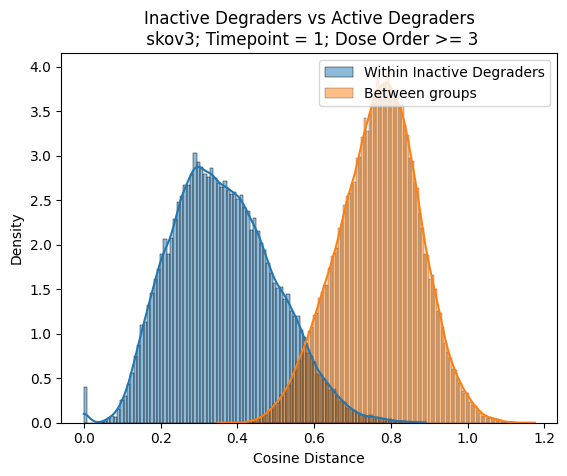

In [61]:
embedding_name = 'skov3' # @param ["skov3", "skov3_noher2"]
TIMEPOINT_ORDER = 1
DOSE_ORDER_CUTOFF = 3
LABEL_VAR = 'label'
NDIMS = 512
pdist_df = dfs[embedding_name].copy()
pdist_df = pdist_df[pdist_df['timepoint_order'] == TIMEPOINT_ORDER]
pdist_df = pdist_df[pdist_df['dose_order'] >= DOSE_ORDER_CUTOFF]
pdist_df['group'] = pdist_df['compound'].map(paper_group_map)
pdist_df['lapatanib active degrader'] = pdist_df['compound'].isin(['Crews Acvite HER2/EGFR degrader (Lapatinib based)'])
pdist_df['lapatanib inactive degrader'] = pdist_df['compound'].isin(['Crews inactive HER2/EGFR degrader (Lapatinib based)'])
pdist_df['tucatinib active degrader'] = pdist_df['compound'].isin(['C4T VHL-based active HER2-degrader (Tucatinib based)'])
pdist_df['tucatinib inactive degrader'] = pdist_df['compound'].isin(['C4T VHL-based inactive HER2-degrader (Tucatinib based)'])
groups = {
    'Active Degraders': {'group': 'Active Degraders'},
    'Inactive Degraders': {'group': 'Inactive Degraders'},
    }
group1 = 'Inactive Degraders'
group2 = 'Active Degraders'
distances = get_pdist_distributions(
    pdist_df, groups[group1], groups[group2], ndims=NDIMS,
    groupby_cols=None, metric='cosine', exclude_same_cols=[])
within_group_distances, between_group_distances = distances
sns.histplot(within_group_distances, color=sns.color_palette()[0],
            kde=True, stat='density', label=f'Within {group1}')
sns.histplot(between_group_distances, color=sns.color_palette()[1],
            kde=True, stat='density', label='Between groups')
plt.legend(loc='upper right')
plt.title(f'{group1} vs {group2}\n {embedding_name}; Timepoint = {TIMEPOINT_ORDER}; Dose Order >= {DOSE_ORDER_CUTOFF}')
plt.xlabel('Cosine Distance')
plt.show()